# Trabajo LC

Jaume Ivars Grimalt y Iñaki Diez Lambies

#### Importaciones necesarias

In [24]:
import nltk
from nltk.corpus import cess_esp
from nltk.tag import hmm, tnt, AffixTagger, brill, brill_trainer, UnigramTagger, PerceptronTagger
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import t
import scipy.stats as stats
from IPython.display import display
from sklearn.model_selection import train_test_split

nltk.download("cess_esp")
cess_sents = list(cess_esp.tagged_sents())
np.random.shuffle(cess_sents)

[nltk_data] Downloading package cess_esp to
[nltk_data]     C:\Users\NachoDíez\AppData\Roaming\nltk_data...
[nltk_data]   Package cess_esp is already up-to-date!


## Ejercicio 1

Evaluación del etiquetador ‘hmm’ sobre el corpus ‘cess-esp’ utilizando el juego de
categorías completo y reducido.

Utilizando el etiquetador hmm basado en modelos de Markov, se realizará una validación cruzada
sobre 10 particiones del corpus. Barajar el corpus antes de realizar las particiones. Presentar los
resultados en forma de tabla y gráficamente, incluyendo los intervalos de confianza.

In [2]:
def show_accuracy_table(accuracies, title, labels):
    mean_acc = np.mean(accuracies)
    conf_int = stats.t.interval(0.95, len(accuracies) - 1, loc=mean_acc, scale=stats.sem(accuracies))
    
    data = {
        title: labels + ["Media", "Intervalo de Confianza"],
        "Accuracy": accuracies + [mean_acc, f"{conf_int[0]:.4f} - {conf_int[1]:.4f}"]
    }
    df = pd.DataFrame(data)
    display(df)

In [3]:
def show_accuracy_graph(accuracies, title, labels, x_label):
    plt.figure(figsize=(10, 5))

    acc_mean = np.mean(accuracies)
    plt.ylim(max(0, min(accuracies - acc_mean / 2.0)), min(1, max(accuracies + acc_mean / 2.0)))
    
    x = list(range(len(accuracies)))
    plt.plot(x, accuracies, 'ro-')
    
    plt.xticks(x, labels)
    plt.xlabel(x_label)
    plt.ylabel('Accuracy')
    plt.title(title)
    
    conf_int = stats.t.interval(0.95, len(accuracies) - 1, loc=acc_mean, scale=stats.sem(accuracies))
    error_y = (conf_int[1] - conf_int[0]) / 2
    plt.errorbar(x, accuracies, yerr=error_y, linestyle='None', color='blue', capsize=5)
    
    plt.grid(True)
    plt.show()


In [4]:
def cross_validate_hmm(sentences, num_partitions):
    partition_size = len(sentences) // num_partitions
    partitions = [sentences[i * partition_size: (i + 1) * partition_size] for i in range(num_partitions)]

    accuracies = []
    for i in range(num_partitions):
        test_data = partitions[i]
        train_data = [sentence for part_idx, partitions in enumerate(partitions) if part_idx != i for sentence in partitions]

        trainer = hmm.HiddenMarkovModelTrainer()
        hmm_tagger = trainer.train(train_data)
        acc = hmm_tagger.accuracy(test_data)
        accuracies.append(acc)
        print(f"Accuracy for partition {i}: {acc}")

    mean_acc = np.mean(accuracies)
    conf_int = t.interval(0.95, len(accuracies) - 1, loc=mean_acc, scale=stats.sem(accuracies))
    print("Mean accuracy: ", mean_acc)
    print("Confidence interval: ", conf_int)

    return accuracies

### Con todas las categorías

Realizar experimentos

In [5]:
all_categories_accuracies = cross_validate_hmm(cess_sents, 10)

c:\MUIARFID\LC\Treball_LC\.venv\Lib\site-packages\nltk\tag\hmm.py:334: RuntimeWarning: overflow encountered in cast
  X[i, j] = self._transitions[si].logprob(self._states[j])
c:\MUIARFID\LC\Treball_LC\.venv\Lib\site-packages\nltk\tag\hmm.py:336: RuntimeWarning: overflow encountered in cast
  O[i, k] = self._output_logprob(si, self._symbols[k])
c:\MUIARFID\LC\Treball_LC\.venv\Lib\site-packages\nltk\tag\hmm.py:332: RuntimeWarning: overflow encountered in cast
  P[i] = self._priors.logprob(si)
c:\MUIARFID\LC\Treball_LC\.venv\Lib\site-packages\nltk\tag\hmm.py:364: RuntimeWarning: overflow encountered in cast
  O[i, k] = self._output_logprob(si, self._symbols[k])


Accuracy for partition 0: 0.2990722784213009
Accuracy for partition 1: 0.2693022800665427
Accuracy for partition 2: 0.26768037554852536
Accuracy for partition 3: 0.2661481405171526
Accuracy for partition 4: 0.27902748194711413
Accuracy for partition 5: 0.26968493225227186
Accuracy for partition 6: 0.2890356808488505
Accuracy for partition 7: 0.2777892775822811
Accuracy for partition 8: 0.28216321709208564
Accuracy for partition 9: 0.2863317125877904
Mean accuracy:  0.27862353768639153
Confidence interval:  (0.27092798690672604, 0.286319088466057)


Mostrar resultados

,Accuracy por fold,Accuracy
0,Fold 0,0.299072
1,Fold 1,0.269302
2,Fold 2,0.26768
3,Fold 3,0.266148
4,Fold 4,0.279027
5,Fold 5,0.269685
6,Fold 6,0.289036
7,Fold 7,0.277789
8,Fold 8,0.282163
9,Fold 9,0.286332


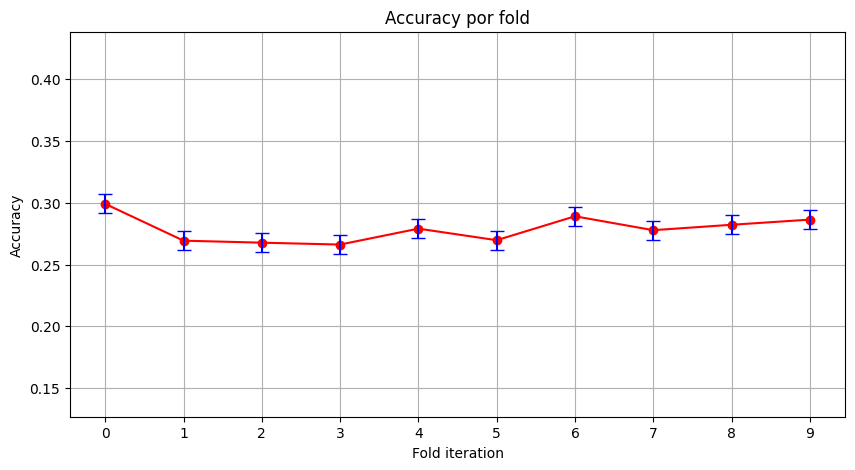

In [6]:
show_accuracy_table(all_categories_accuracies, "Accuracy por fold", ["Fold " + str(i) for i in range(10)])
show_accuracy_graph(all_categories_accuracies, "Accuracy por fold", list(range(10)), "Fold iteration")

### Juego de categorías reducido
Preprocesado para reducir las categorías

In [15]:
reduced_cess_sents = []
for sentence in cess_sents:
    new_line = []
    for word, key in sentence:
        if word == "*0*" and key == "sn":
            continue
        elif key[0] == 'v' or key[0] == 'F':
            key = key[:3]
        else:
            key = key[:2]
        new_line.append((word,key))
    reduced_cess_sents.append(new_line)

Realizar experimento

In [16]:
reduced_categories_accuracies = cross_validate_hmm(reduced_cess_sents, 10)

c:\MUIARFID\LC\Treball_LC\.venv\Lib\site-packages\nltk\tag\hmm.py:334: RuntimeWarning: overflow encountered in cast
  X[i, j] = self._transitions[si].logprob(self._states[j])
c:\MUIARFID\LC\Treball_LC\.venv\Lib\site-packages\nltk\tag\hmm.py:336: RuntimeWarning: overflow encountered in cast
  O[i, k] = self._output_logprob(si, self._symbols[k])
c:\MUIARFID\LC\Treball_LC\.venv\Lib\site-packages\nltk\tag\hmm.py:332: RuntimeWarning: overflow encountered in cast
  P[i] = self._priors.logprob(si)
c:\MUIARFID\LC\Treball_LC\.venv\Lib\site-packages\nltk\tag\hmm.py:364: RuntimeWarning: overflow encountered in cast
  O[i, k] = self._output_logprob(si, self._symbols[k])


Accuracy for partition 0: 0.36914932648461657
Accuracy for partition 1: 0.3044818475388981
Accuracy for partition 2: 0.30947035411776713
Accuracy for partition 3: 0.30261666838364065
Accuracy for partition 4: 0.31778274196062134
Accuracy for partition 5: 0.3027697665560211
Accuracy for partition 6: 0.3232081556225944
Accuracy for partition 7: 0.31261643552059615
Accuracy for partition 8: 0.3192440039032407
Accuracy for partition 9: 0.3204754186925986
Mean accuracy:  0.31818147187805945
Confidence interval:  (0.3042695494928558, 0.3320933942632631)


Mostrar resultados

,Accuracy por fold,Accuracy
0,Fold 0,0.369149
1,Fold 1,0.304482
2,Fold 2,0.30947
3,Fold 3,0.302617
4,Fold 4,0.317783
5,Fold 5,0.30277
6,Fold 6,0.323208
7,Fold 7,0.312616
8,Fold 8,0.319244
9,Fold 9,0.320475


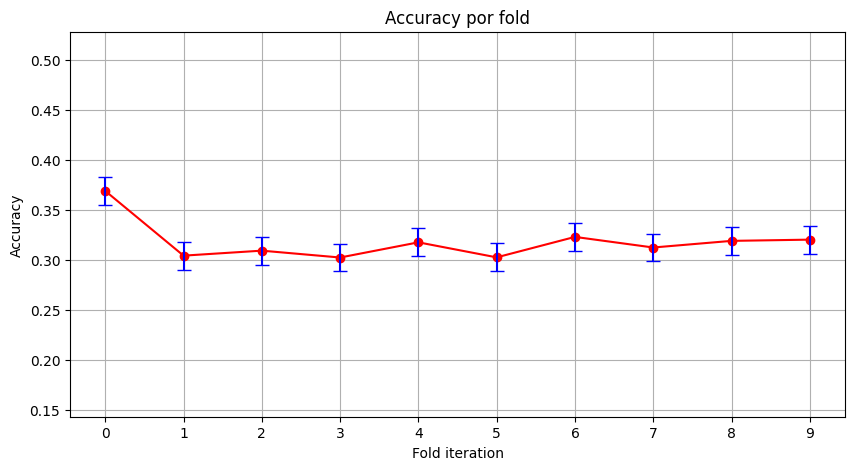

In [18]:
show_accuracy_table(reduced_categories_accuracies, "Accuracy por fold", ["Fold " + str(i) for i in range(10)])
show_accuracy_graph(reduced_categories_accuracies, "Accuracy por fold", list(range(10)), "Fold iteration")

## Ejercicio 2

Evaluación de las prestaciones del etiquetador respecto a la cantidad de datos de 
aprendizaje.

Se trata de estudiar cómo varían las prestaciones del etiquetador hmm cuando varía el tamaño del
corpus de aprendizaje. Para este experimento se dividirá el corpus de entrenamiento en 10 partes
de tamaño similar. La partición 10 se tomará como test, y las 9 particiones restantes se tomarán
como entrenamiento. En cada ejecución, se irá incrementando sucesivamente el tamaño del corpus
de entrenamiento, manteniendo fija la partición de test.
Importante: Para esta tarea no es necesario realizar la validación cruzada. 

In [10]:
def accumulated_validation(sentences, num_partitions):
    partition_size = len(sentences) // num_partitions
    partitions = [sentences[i * partition_size: (i + 1) * partition_size] for i in range(num_partitions)]

    train_data = []
    test_data = partitions[-1]

    accuracies = []
    for i in range(num_partitions-1):
        train_data += partitions[i]

        trainer = hmm.HiddenMarkovModelTrainer()
        hmm_tagger = trainer.train(train_data)
        acc = hmm_tagger.accuracy(test_data)
        accuracies.append(acc)
        print(f"Accuracy for partition {i}: {acc}")

    mean_acc = np.mean(accuracies)
    conf_int = t.interval(0.95, len(accuracies) - 1, loc=mean_acc, scale=stats.sem(accuracies))
    print("Mean accuracy: ", mean_acc)
    print("Confidence interval: ", conf_int)

    return accuracies

Realizar experimentos

In [11]:
accumulated_categories_accuracies = accumulated_validation(cess_sents, 10)

c:\MUIARFID\LC\Treball_LC\.venv\Lib\site-packages\nltk\tag\hmm.py:334: RuntimeWarning: overflow encountered in cast
  X[i, j] = self._transitions[si].logprob(self._states[j])
c:\MUIARFID\LC\Treball_LC\.venv\Lib\site-packages\nltk\tag\hmm.py:336: RuntimeWarning: overflow encountered in cast
  O[i, k] = self._output_logprob(si, self._symbols[k])
c:\MUIARFID\LC\Treball_LC\.venv\Lib\site-packages\nltk\tag\hmm.py:332: RuntimeWarning: overflow encountered in cast
  P[i] = self._priors.logprob(si)
c:\MUIARFID\LC\Treball_LC\.venv\Lib\site-packages\nltk\tag\hmm.py:364: RuntimeWarning: overflow encountered in cast
  O[i, k] = self._output_logprob(si, self._symbols[k])


Accuracy for partition 0: 0.044408427876823336
Accuracy for partition 1: 0.09324689357104268
Accuracy for partition 2: 0.13144246353322528
Accuracy for partition 3: 0.16639654240950838
Accuracy for partition 4: 0.1930848190167477
Accuracy for partition 5: 0.21858454889249054
Accuracy for partition 6: 0.2439222042139384
Accuracy for partition 7: 0.26704484062668826
Accuracy for partition 8: 0.2863317125877904
Mean accuracy:  0.18271805030313945
Confidence interval:  (0.1201430657302017, 0.2452930348760772)


Mostrar resultados

,Accuracy por number of partitions,Accuracy
0,Number of partitions 1,0.044408
1,Number of partitions 2,0.093247
2,Number of partitions 3,0.131442
3,Number of partitions 4,0.166397
4,Number of partitions 5,0.193085
5,Number of partitions 6,0.218585
6,Number of partitions 7,0.243922
7,Number of partitions 8,0.267045
8,Number of partitions 9,0.286332
9,Media,0.182718


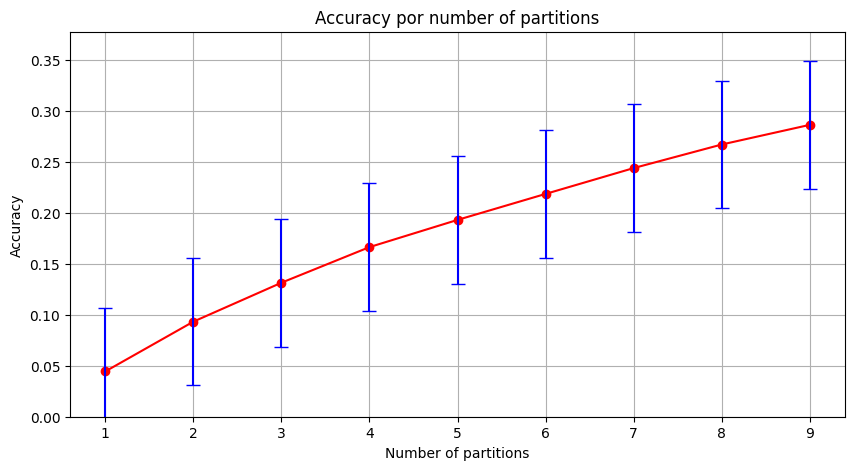

In [14]:
show_accuracy_table(accumulated_categories_accuracies, "Accuracy por number of partitions", ["Number of partitions " + str(i) for i in range(1, 10)])
show_accuracy_graph(accumulated_categories_accuracies, "Accuracy por number of partitions", list(range(1, 10)), "Number of partitions")

## Ejercicio 3

Evaluación del método de suavizado para palabras desconocidas para el etiquetador tnt.

El etiquetador tnt por defecto no incorpora un método de suavizado para las palabras desconocidas. 
Utiliza un método basado en los sufijos de las palabras para construir un modelo para las palabras 
desconocidas (Affix Tagger). En base al sufijo de la palabra desconocida le asigna una categoría 
morfosintáctica. Este método funciona razonablemente bien para el inglés.

En concreto, se trata de estudiar diferentes longitudes del sufijo (número de letras que se tienen en 
cuenta) y estudiar cómo varían las prestaciones del etiquetador. Una vez se haya decidido el sufijo 
que mejores prestaciones proporciona, incorporarlo como modelo de suavizado al etiquetador tnt y 
comprobar si aumenta sus prestaciones.

In [22]:
def cross_validate_tnt(sentences, num_partitions, affix_length=None):
    partition_size = len(sentences) // num_partitions
    partitions = [sentences[i * partition_size: (i + 1) * partition_size] for i in range(num_partitions)]

    accuracies = []
    for i in range(num_partitions):
        test_data = partitions[i]
        train_data = [sentence for part_idx, partitions in enumerate(partitions) if part_idx != i for sentence in partitions]

        if affix_length is not None:
            affix_tagger = AffixTagger(train_data, affix_length=affix_length)
            tnt_tagger = tnt.TnT(unk=affix_tagger, Trained=True)
        else:
            tnt_tagger = tnt.TnT()

        tnt_tagger.train(train_data)
        accuracy = tnt_tagger.accuracy(test_data)
        accuracies.append(accuracy)
        print(f"Accuracy for {affix_length} affix length: {accuracy} for partition {i}")

    mean_acc = np.mean(accuracies)
    conf_int = t.interval(0.95, len(accuracies) - 1, loc=mean_acc, scale=stats.sem(accuracies))

    print(f"Mean accuracy for {affix_length} affix length: ", mean_acc)
    print(f"Confidence interval for {affix_length} affix length: ", conf_int)
    print("")

    return accuracies

Evaluar diferentes longitudes de sufijo

In [23]:
suffix_lengths = range(1, 10)

suffix_accuracies = []
for suffix_length in suffix_lengths:
    suffix_accuracies.append(cross_validate_tnt(cess_sents, 10, suffix_length))

Accuracy for 1 affix length: 0.9048922870279485 for partition 0
Accuracy for 1 affix length: 0.9113619734504024 for partition 1
Accuracy for 1 affix length: 0.9055953189488533 for partition 2
Accuracy for 1 affix length: 0.9085352777182072 for partition 3
Accuracy for 1 affix length: 0.9089977454396393 for partition 4
Accuracy for 1 affix length: 0.9075246497145822 for partition 5
Accuracy for 1 affix length: 0.9114262642575957 for partition 6
Accuracy for 1 affix length: 0.9059117402164862 for partition 7
Accuracy for 1 affix length: 0.9071622185154296 for partition 8
Accuracy for 1 affix length: 0.907535305638594 for partition 9
Mean accuracy for 1 affix length:  0.9078942780927738
Confidence interval for 1 affix length:  (0.9062918967987458, 0.9094966593868018)

Accuracy for 2 affix length: 0.9075786537170016 for partition 0
Accuracy for 2 affix length: 0.9125117591721543 for partition 1
Accuracy for 2 affix length: 0.9089389269108197 for partition 2
Accuracy for 2 affix length: 0.9

Etiquetador TNT con el mejor sufijo encontrado

Best suffix length: 1


,Accuracy por fold,Accuracy
0,Fold 0,0.907579
1,Fold 1,0.912512
2,Fold 2,0.908939
3,Fold 3,0.909876
4,Fold 4,0.909151
5,Fold 5,0.90903
6,Fold 6,0.913142
7,Fold 7,0.907681
8,Fold 8,0.908622
9,Fold 9,0.908308


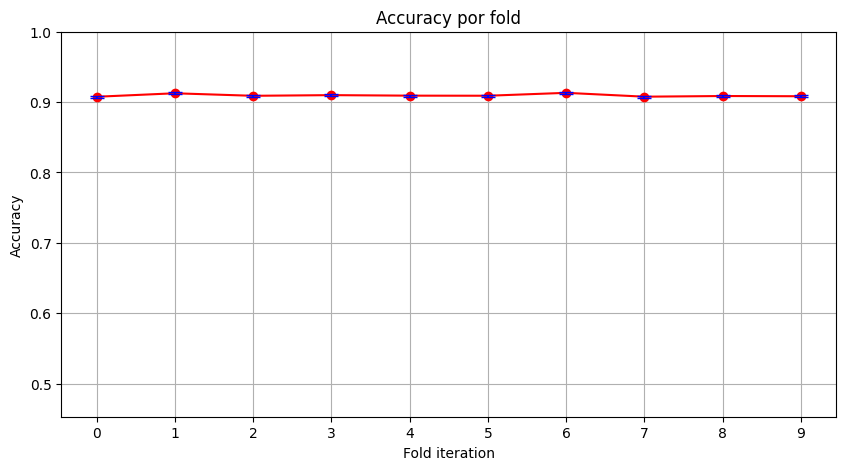

In [25]:
best_sufix_length = suffix_accuracies.index(max(suffix_accuracies))
print(f"Best suffix length: {best_sufix_length}")

best_accuraces = suffix_accuracies[best_sufix_length]
show_accuracy_table(best_accuraces, "Accuracy por fold", ["Fold " + str(i) for i in range(10)])
show_accuracy_graph(best_accuraces, "Accuracy por fold", list(range(10)), "Fold iteration")

## Ejercicio 4

Evaluación del resto de etiquetadores.


Se deberán utilizar otros paradigmas de etiquetado. Como mínimo el etiquetador de Brill y algún otro 
como, CRF, perceptron. Se deberá realizar una comparativa de prestaciones respecto a los
etiquetadores tnt y hmm, utilizando el juego de categorías reducido. 

Cuando se utilice el etiquetador de Brill, probar con diferentes etiquetados iniciales, por ejemplo 
probar con Unigram Tagger y con hmm tagger.

La comparación puede ser sólo de una partición, si el coste temporal de la validación cruzada 
requiere mucho tiempo

In [26]:
reduced_tags_train_data, reduced_tags_test_data = train_test_split(reduced_cess_sents, test_size=0.1, random_state=42)
templates = brill.fntbl37()

### Brill

Unigram Tagger

In [27]:
unigram_tagger = UnigramTagger(reduced_tags_train_data)

brill_tagger_unigram = brill_trainer.BrillTaggerTrainer(unigram_tagger, templates, deterministic=True)
brill_tagger_unigram = brill_tagger_unigram.train(reduced_tags_train_data)

accuracy_brill_unigram = brill_tagger_unigram.accuracy(reduced_tags_test_data)
print("Precisión del etiquetador de Brill con Unigram: {:.4f}".format(accuracy_brill_unigram))

Precisión del etiquetador de Brill con Unigram: 0.8969


HNN Tagger

In [28]:
hmm_tagger = hmm.HiddenMarkovModelTagger.train(reduced_tags_train_data)

brill_tagger_hmm = brill_trainer.BrillTaggerTrainer(hmm_tagger, templates, deterministic=True)
brill_tagger_hmm = brill_tagger_hmm.train(reduced_tags_train_data)

accuracy_brill_hmm = brill_tagger_hmm.accuracy(reduced_tags_test_data)
print("Precisión del etiquetador de Brill con HMM: {:.4f}".format(accuracy_brill_hmm))

Precisión del etiquetador de Brill con HMM: 0.9318


### Perceptron

In [29]:
perceptron_tagger = PerceptronTagger(load=False)
perceptron_tagger.train(reduced_tags_train_data)

accuracy_perceptron = perceptron_tagger.accuracy(reduced_tags_test_data)
print("Precisión del etiquetador Perceptron: {:.4f}".format(accuracy_perceptron))

Precisión del etiquetador Perceptron: 0.9680
